# scanpy单细胞转录组流程
ref:https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

## 数据加载与预处理

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [ ]:
## 从 Figshare 下载示例数据
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [ ]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

## 读取示例数据
# 数据是10x Genomics格式的h5文件
for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

## 质控
使用函数`calculate_qc_metrics()`来计算QC指标，类似于`scater`的`calculateQCMetrics`

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


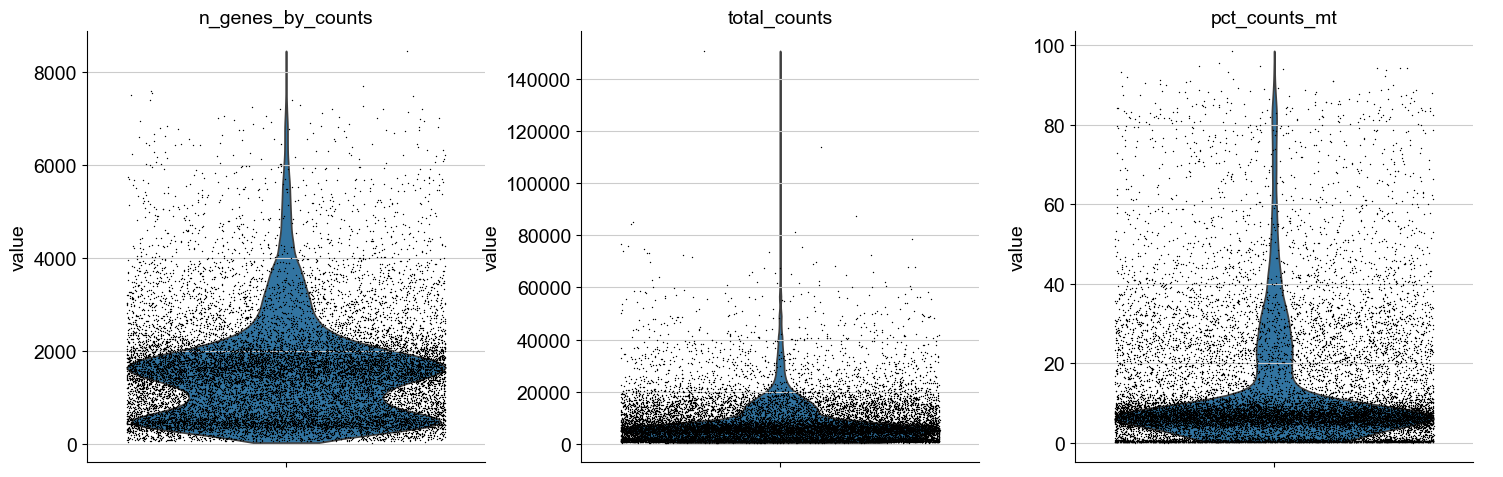

In [7]:
## 小提琴图可视化QC指标分布情况
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

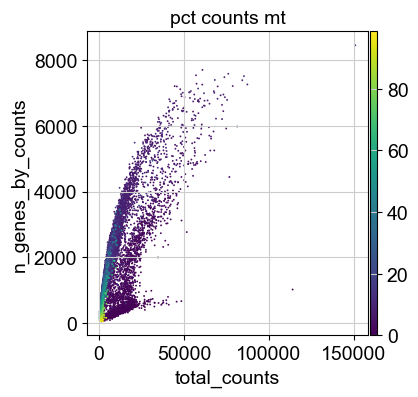

In [8]:
## 散点图可视化QC指标间的关联
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
## 过滤一下底质量细胞
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### 去除双胞
Scanpy 提供的 `Scrublet` 算法通过模拟双细胞并基于最近邻分类器预测每个细胞的双细胞概率，运行 `sc.pp.scrublet()` 会在 `.obs` 中添加 `doublet_score` 和 `predicted_doublet`。检测后可直接删除预测为双细胞的细胞，或在聚类后去除双细胞比例较高的聚类。

In [11]:
## 这里先不去除双胞，等到聚类的时候再处理
sc.pp.scrublet(adata, batch_key="sample")

## 标准化

In [12]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [ ]:
# Normalizing to median total counts（默认）
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## 特征选择

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

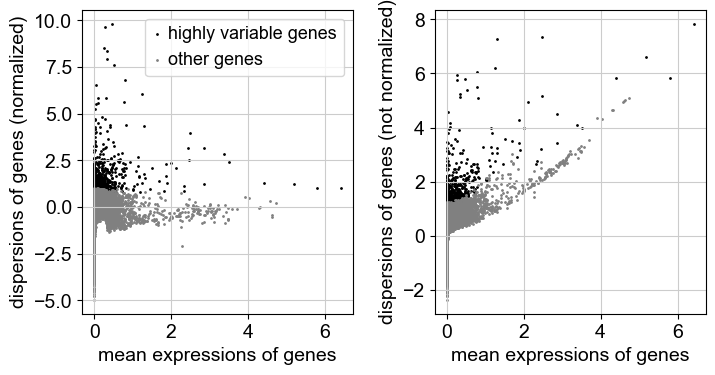

In [15]:
sc.pl.highly_variable_genes(adata)

## 降维PCA

In [16]:
sc.tl.pca(adata)

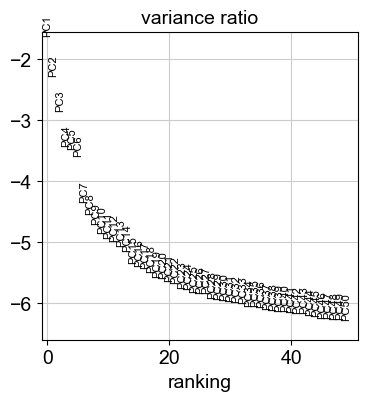

In [17]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

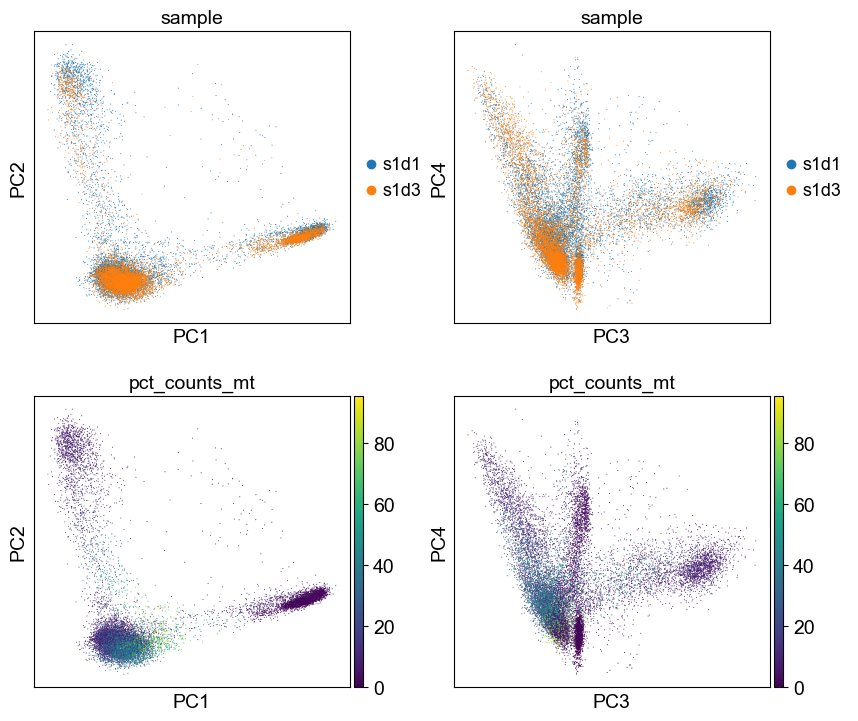

In [18]:
## 看看某些变量是否与pc强相关
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## 构建细胞邻接图

/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


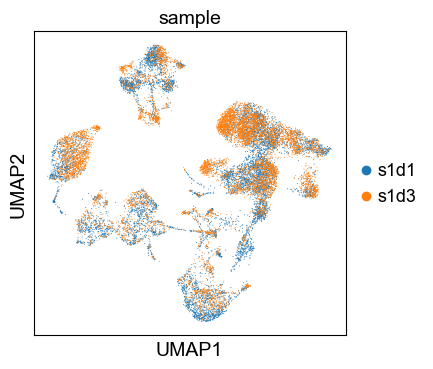

In [19]:
## 构建图
sc.pp.neighbors(adata)

## UMAP降维
sc.tl.umap(adata)

## 可视化
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

多样本来源的数据通常需要检查是否存在批次效应。从上面这个umap图可以看出，批次效应较为微弱。
因为细胞每一块在两个样本中分布的都较为均匀。

## 细胞聚类

In [21]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

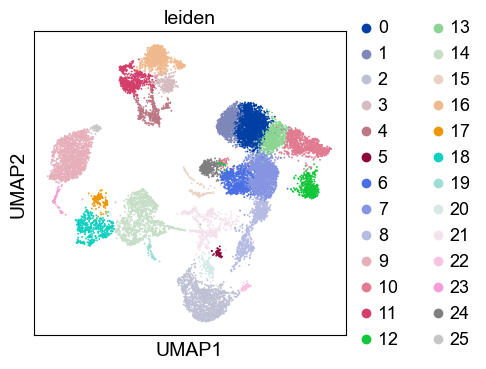

In [22]:
sc.pl.umap(adata, color=["leiden"])

### 重新评估质控效果

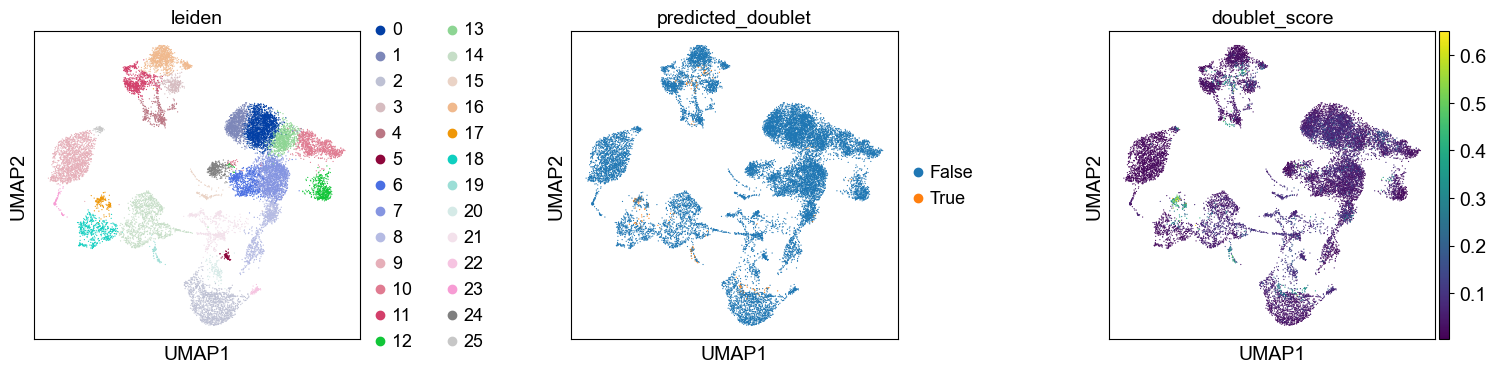

In [23]:
## 使用UMAP来评估双细胞质控情况
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

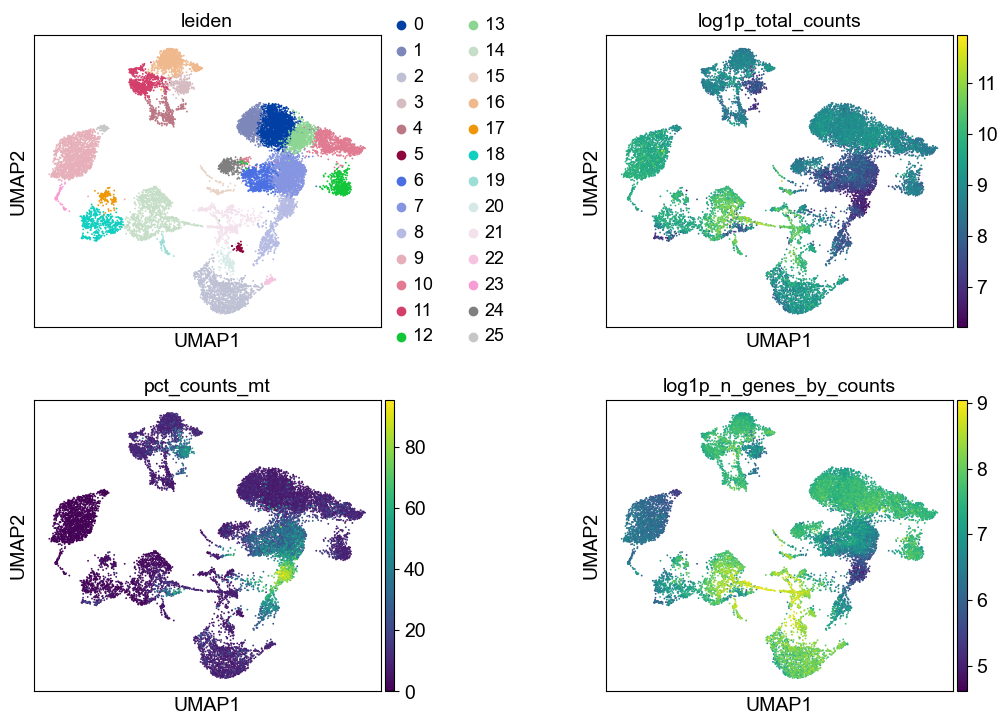

In [24]:
## 评估测序深度等指标
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

## 细胞注释
### 确定细胞亚群个数

In [25]:
## 不同分辨率的聚类结果
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

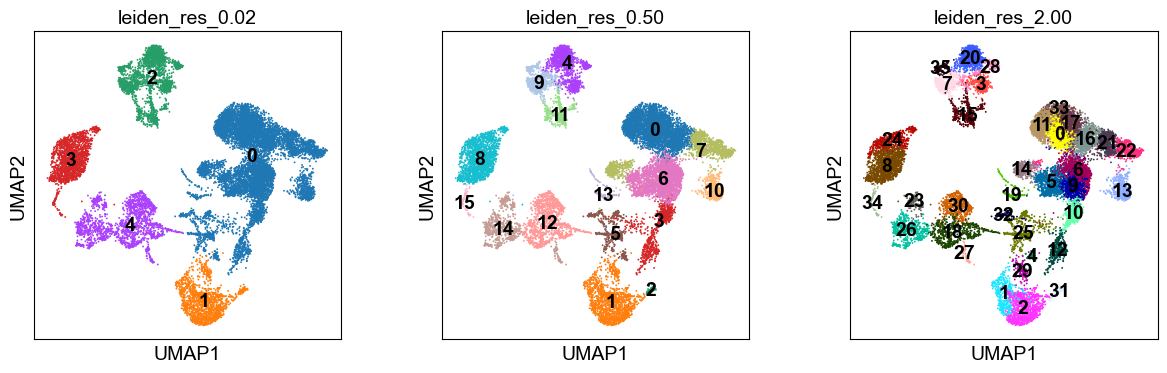

In [26]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

原文：Though UMAPs should not be over-interpreted, here we can already see that in the highest resolution our data is over-clustered, while the lowest resolution is likely grouping cells which belong to distinct cell identities.

### 根据先验marker来进行细胞注释

In [27]:
## 导入一个预先定义的marker基因字典
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

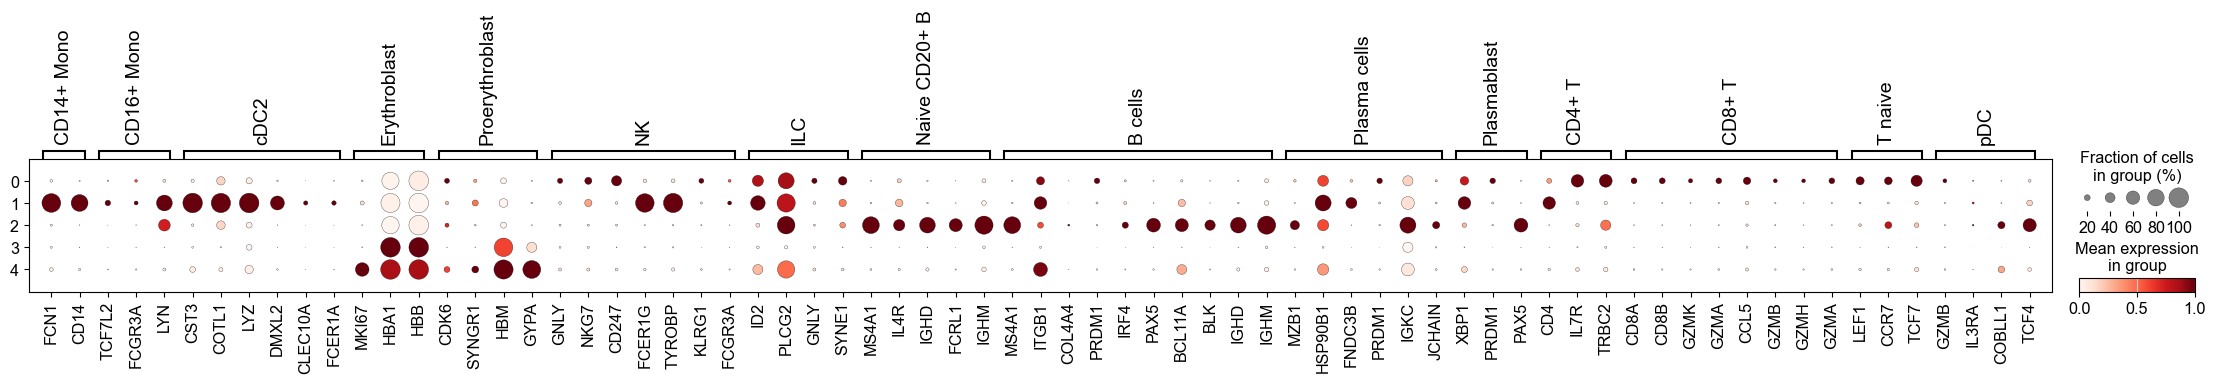

In [ ]:
## 散点图可视化0.02分辨率的聚类结果
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

In [29]:
## 根据dotplot来进行细胞注释
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

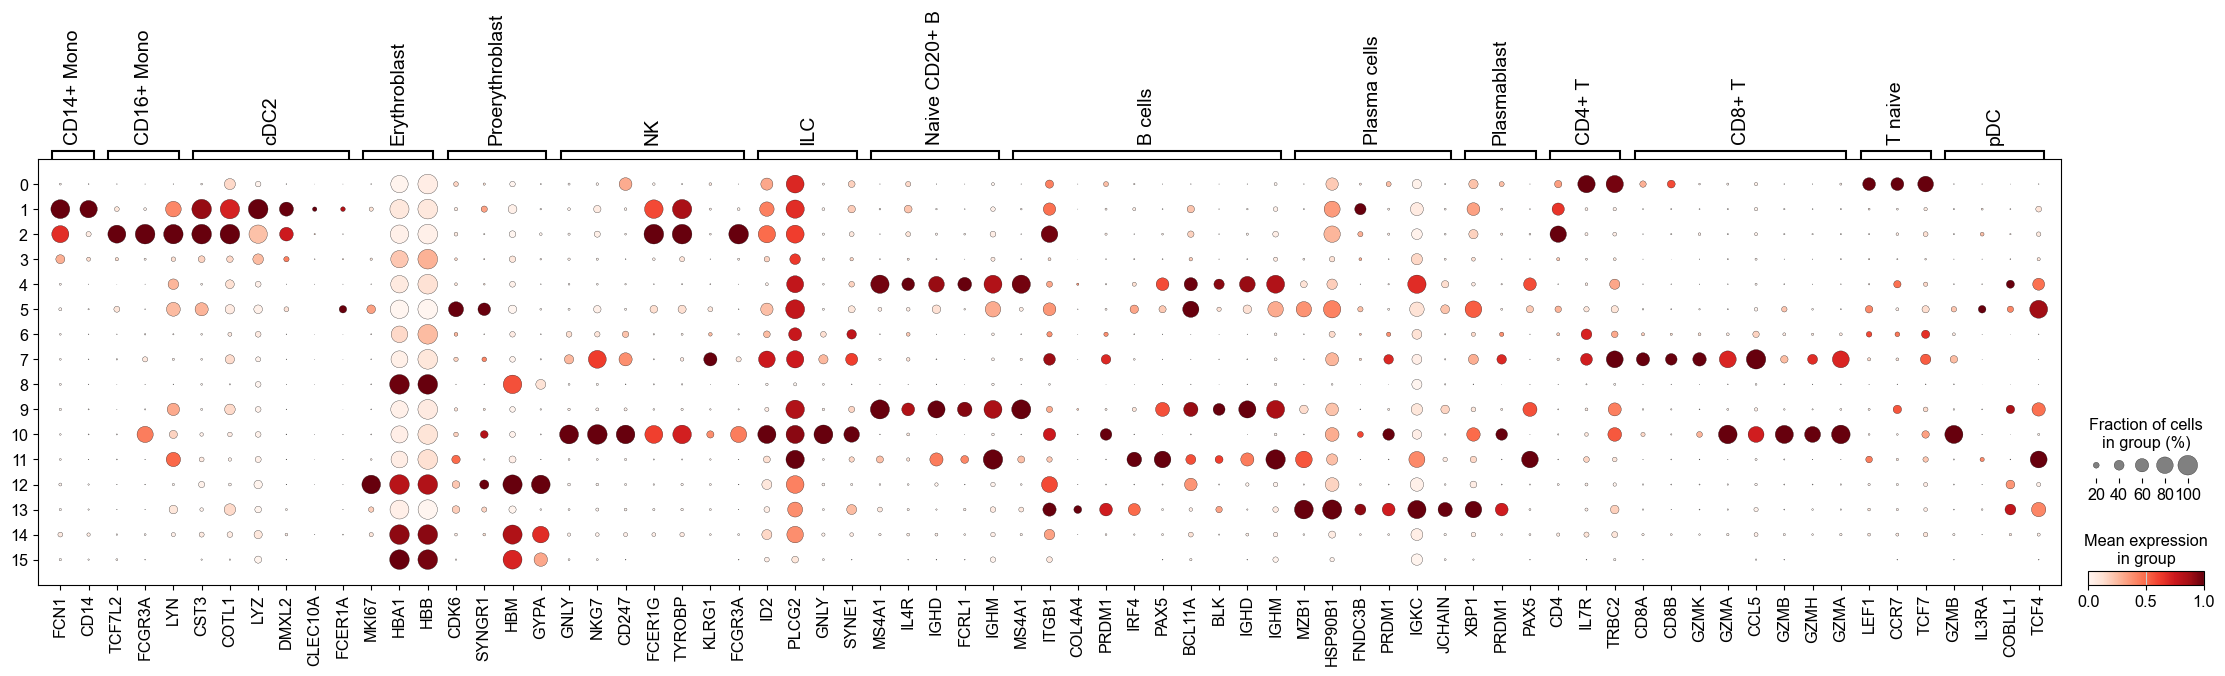

In [30]:
## 同理根据0.50分辨率的聚类结果进行细胞注释
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

## 细胞差异表达基因分析

In [31]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

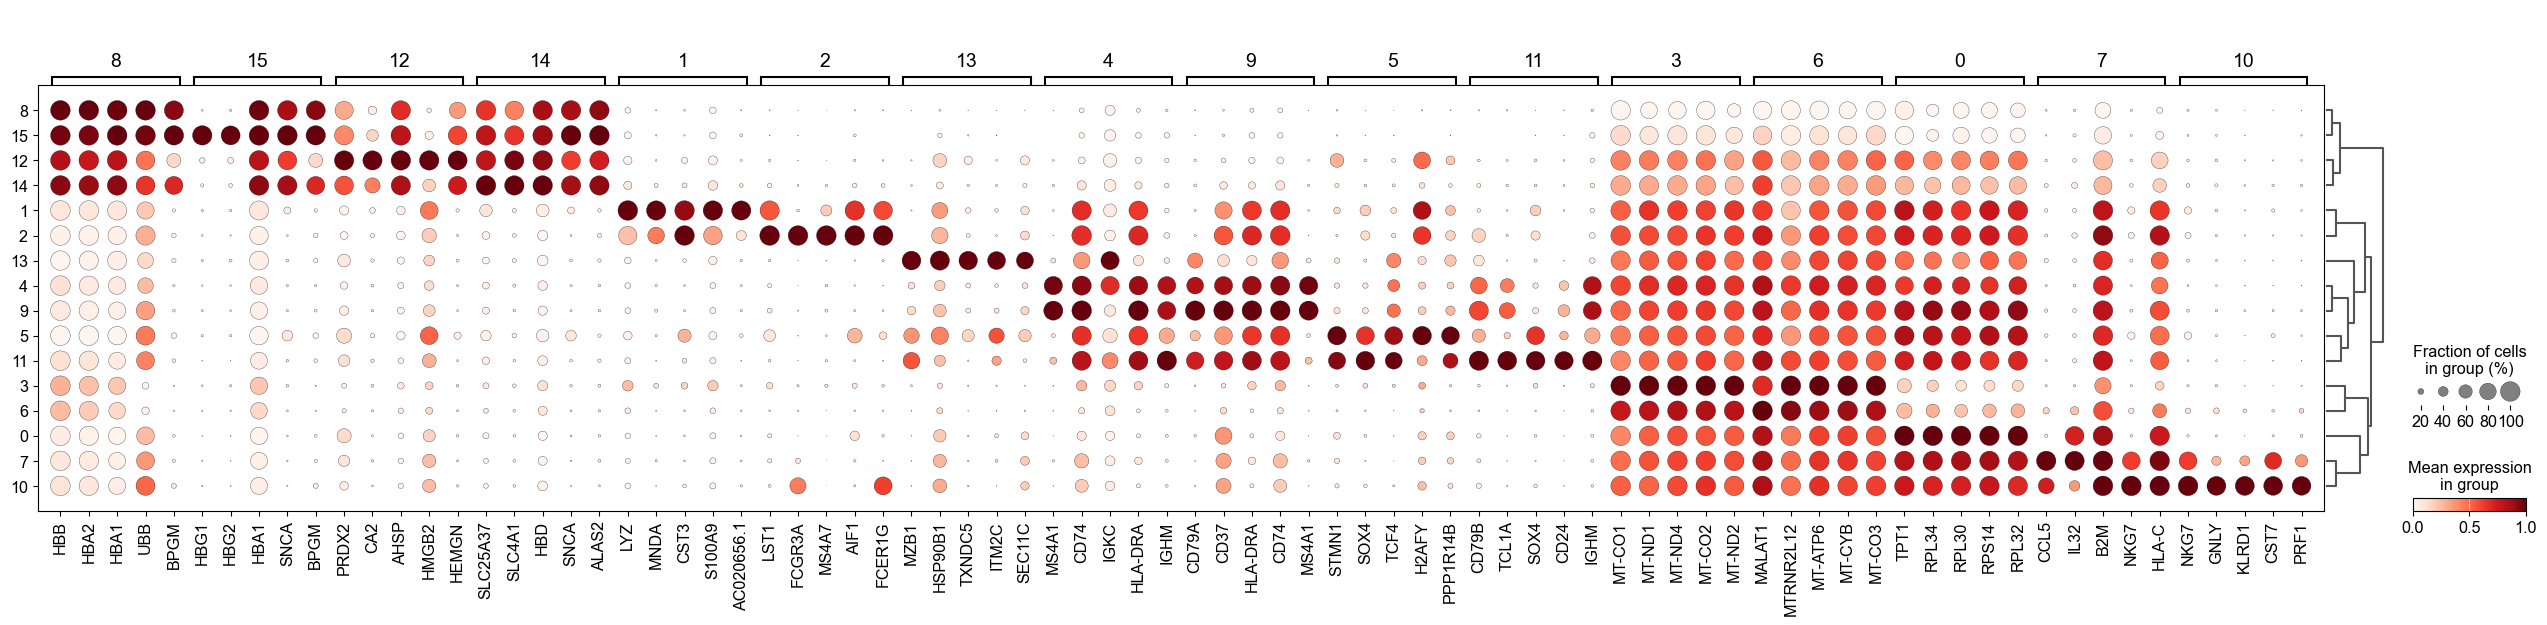

In [32]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

In [33]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CCL5,56.237030,6.076925,0.0,0.0
1,IL32,50.258617,3.550686,0.0,0.0
2,B2M,49.776669,2.186693,0.0,0.0
3,NKG7,47.669384,4.959451,0.0,0.0
4,HLA-C,46.815411,2.212958,0.0,0.0


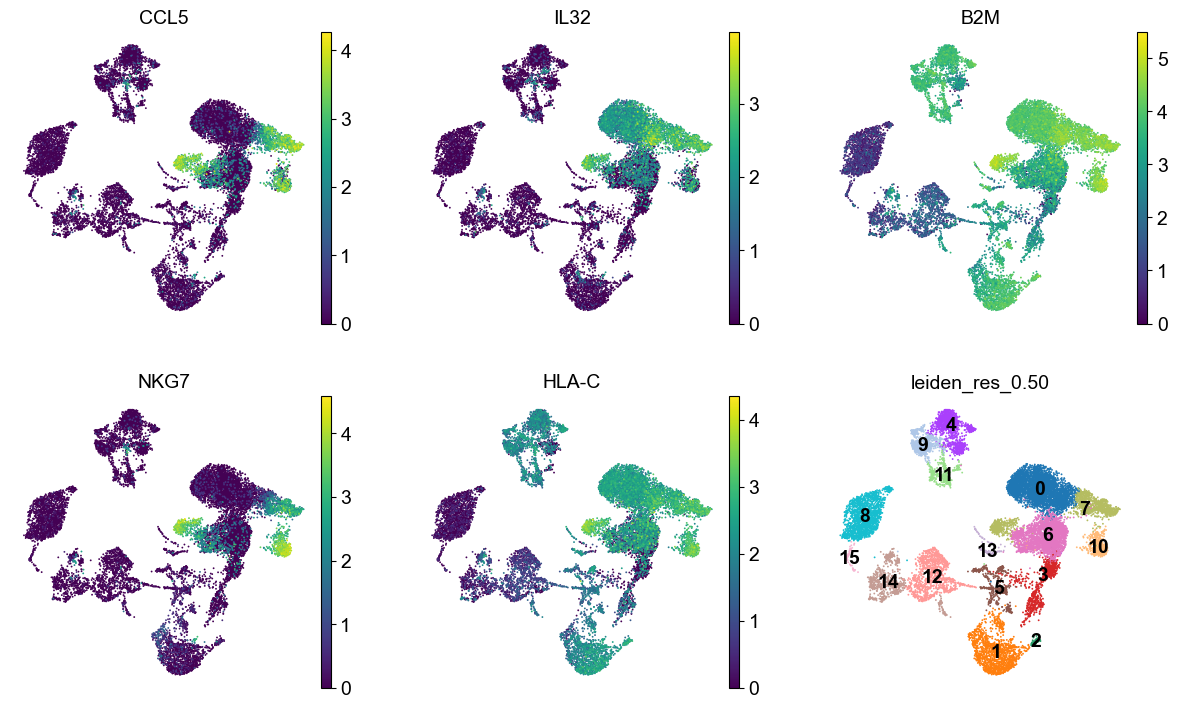

In [ ]:
## 可视化group7前5个差异表达基因的表达情况
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)